# Code to generate all figures on heatwaves events used in the paper
## note this is spread across multiple figures
## TODO: Update the specific list once we are done

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults, inputs, metrics
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path
import multiprocessing
from datetime import timedelta
from matplotlib.patches import Patch

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [2]:
# setup the templates to load in the data

# Forecast Examples
cira_heatwave_forecast_FOURv2 = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/FOUR_v200_IFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="CIRA FOURv2",
)

cira_heatwave_forecast_GC = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/GRAP_v100_IFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="CIRA GC",
)

cira_heatwave_forecast_PANG = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/PANG_v100_IFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=defaults._preprocess_bb_cira_forecast_dataset,
    name="CIRA PANG",
)

hres_forecast = inputs.ZarrForecast(
    source="gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr",
    variables=["surface_air_temperature"],
    variable_mapping=inputs.HRES_metadata_variable_mapping,
    storage_options={"remote_options": {"anon": True}},
    name="ECMWF HRES",
)


FOURv2_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_FOURv2, 
    ),
]

FOURv2_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_heatwave_forecast_FOURv2, 
    ),
]

GC_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_GC, 
    ),
]

GC_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_heatwave_forecast_GC, 
    ),
]

PANG_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_PANG, 
    ),
]

PANG_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.era5_heatwave_target,
        forecast=cira_heatwave_forecast_PANG, 
    ),
]

HRES_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.ghcn_heatwave_target,
        forecast=hres_forecast,
    ),
]

HRES_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=defaults.era5_heatwave_target,
        forecast=hres_forecast,
    ),
]

In [33]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

fourv2_color = sns_palette[0]
gc_color = sns_palette[1]
pangu_color = sns_palette[2]
hres_color = sns_palette[3]

In [3]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()
heat_test = {"cases": case_dict["cases"]}

# turn the dictionary into a list of case objects ()
ewb_cases = cases.load_individual_cases(case_dict)

ewb_fourv2_ghcn = evaluate.ExtremeWeatherBench(heat_test, FOURv2_GHCN_EVALUATION_OBJECTS)
ewb_fourv2_era5 = evaluate.ExtremeWeatherBench(heat_test, FOURv2_ERA5_EVALUATION_OBJECTS)

ewb_gc_ghcn = evaluate.ExtremeWeatherBench(heat_test, GC_GHCN_EVALUATION_OBJECTS)
ewb_gc_era5 = evaluate.ExtremeWeatherBench(heat_test, GC_ERA5_EVALUATION_OBJECTS)

ewb_pang_ghcn = evaluate.ExtremeWeatherBench(heat_test, PANG_GHCN_EVALUATION_OBJECTS)
ewb_pang_era5 = evaluate.ExtremeWeatherBench(heat_test, PANG_ERA5_EVALUATION_OBJECTS)

ewb_hres_ghcn = evaluate.ExtremeWeatherBench(heat_test, HRES_GHCN_EVALUATION_OBJECTS)
ewb_hres_era5 = evaluate.ExtremeWeatherBench(heat_test, HRES_ERA5_EVALUATION_OBJECTS)

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [5]:
# load in the results for all heat waves in parallel
# this will take awhile to run if you do them all in one code box 
n_threads_per_process = 4
n_processes = max(1, multiprocessing.cpu_count() // n_threads_per_process)

fourv2_ghcn_results = ewb_fourv2_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
fourv2_era5_results = ewb_fourv2_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

gc_ghcn_results = ewb_gc_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
gc_era5_results = ewb_gc_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

pang_ghcn_results = ewb_pang_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
pang_era5_results = ewb_pang_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

hres_ghcn_results = ewb_hres_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
hres_era5_results = ewb_hres_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

  0%|          | 0/46 [00:00<?, ?it/s]

Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
Forecast dataset for case 28 has no data for case time range 2021-01-12 18:00:00 to 2021-01-18 18:00:00.
Forecast dataset for case 27 has no data for case time range 2021-05-30 00:00:00 to 2021-06-09 00:00:00.
Forecast dataset for case 29 has no data for case time range 2020-11-25 00:00:00 to 2020-12-01 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be cause

  0%|          | 0/46 [00:00<?, ?it/s]

Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

  0%|          | 0/46 [00:00<?, ?it/s]

/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

  0%|          | 0/46 [00:00<?, ?it/s]

/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

  0%|          | 0/46 [00:00<?, ?it/s]

Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

  0%|          | 0/46 [00:00<?, ?it/s]

Forecast dataset for case 1 has no data for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 18 has no data for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

  0%|          | 0/46 [00:00<?, ?it/s]

Forecast dataset for case 11 has no data for case time range 2023-07-29 00:00:00 to 2023-08-04 00:00:00.
Forecast dataset for case 5 has no data for case time range 2023-05-10 00:00:00 to 2023-05-23 00:00:00.
Forecast dataset for case 7 has no data for case time range 2023-11-18 00:00:00 to 2023-11-28 00:00:00.
Forecast dataset for case 10 has no data for case time range 2023-08-17 00:00:00 to 2023-08-28 00:00:00.
Forecast dataset for case 8 has no data for case time range 2023-09-02 00:00:00 to 2023-09-13 00:00:00.
Forecast dataset for case 9 has no data for case time range 2023-07-07 00:00:00 to 2023-07-27 00:00:00.
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_execut

  0%|          | 0/46 [00:00<?, ?it/s]

/home/amy/ExtremeWeatherBench/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Forecast dataset for case 7 has no data for case time range 2023-11-18 00:00:00 to 2023-11-28 00:00:00.
Forecast dataset for case 5 has no data for case time range 2023-05-10 00:00:00 to 2023-05-23 00:00:00.
Forecast dataset for case 11 has no data for case time range 2023-07-29 00:00:00 to 2023-08-04 00:00:00.
Forecast dataset for case 13 has no data for case time range 2023-04-14 00:00:00 to 2023-04-23 00:00:00.
Forecast dataset for case 15 has no data for case time range 2023-04-22 00:00:00 to 2023-05-01 00:00:00.
Forecast dataset for case 12 has no data for case time range 2023-05-24 00:00:00 to 2023-06-01 00:00:00.
Forecast dataset for case 10 has no data for case time range 2023-08-17 00:00:00 to 2023-08-28 00:0

In [6]:
# save the results so I don't have to keep re-running
fourv2_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_ghcn_results.pkl')
fourv2_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_era5_results.pkl')

pang_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_ghcn_results.pkl')
pang_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_era5_results.pkl')

hres_ghcn_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_ghcn_results.pkl')
hres_era5_results.to_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_era5_results.pkl')

In [4]:
# load the results back in
fourv2_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_ghcn_results.pkl')
fourv2_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_fourv2_era5_results.pkl')

pang_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_ghcn_results.pkl')
pang_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_pang_era5_results.pkl')

hres_ghcn_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_ghcn_results.pkl')
hres_era5_results = pd.read_pickle(basepath + 'docs/notebooks/figs/figure2_part2_hres_era5_results.pkl')

In [ ]:
fourv2_ghcn_results


In [18]:
# group the results by metric and lead time
fourv2_ghcn_group = fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_ghcn_group = fourv2_ghcn_group.reset_index()

fourv2_era5_group = fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_era5_group = fourv2_era5_group.reset_index()

gc_ghcn_group = gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_ghcn_group = gc_ghcn_group.reset_index()

gc_era5_group = gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_era5_group = gc_era5_group.reset_index()

pang_ghcn_group = pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
pang_ghcn_group = pang_ghcn_group.reset_index()

pang_era5_group = pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
pang_era5_group = pang_era5_group.reset_index()

hres_ghcn_group = hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
hres_ghcn_group = hres_ghcn_group.reset_index()

hres_era5_group = hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
hres_era5_group = hres_era5_group.reset_index()



In [34]:
def plot_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', forecast_hour=None):
    # make the pivot table so we can plot by lead time
    fourv2_ghcn_pivot = fourv2_ghcn_group[fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    fourv2_era_pivot = fourv2_era5_group[fourv2_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    gc_ghcn_pivot = gc_ghcn_group[gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    gc_era5_pivot = gc_era5_group[gc_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    pang_ghcn_pivot = pang_ghcn_group[pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    pang_era5_pivot = pang_era5_group[pang_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    hres_ghcn_pivot = hres_ghcn_group[hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')
    hres_era5_pivot = hres_era5_group[hres_era5_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = hres_era5_pivot.columns.seconds % 86400 == 0
        my_idxs = [idx for idx, n in enumerate(time_diff) if n]
    elif (forecast_hour == "twelvez"):
            # extract the 12z runs
            time_diff = hres_era5_pivot.columns.seconds % 86400 == 43200
            my_idxs = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        # subset down to only the 0z runs
        fourv2_ghcn_pivot = fourv2_ghcn_pivot.iloc[:, my_idxs]
        fourv2_era_pivot = fourv2_era_pivot.iloc[:, my_idxs]

        gc_ghcn_pivot = gc_ghcn_pivot.iloc[:, my_idxs]
        gc_era5_pivot = gc_era5_pivot.iloc[:, my_idxs]

        pang_ghcn_pivot = pang_ghcn_pivot.iloc[:, my_idxs]
        pang_era5_pivot = pang_era5_pivot.iloc[:, my_idxs]    

        hres_ghcn_pivot = hres_ghcn_pivot.iloc[:, my_idxs]
        hres_era5_pivot = hres_era5_pivot.iloc[:, my_idxs]
    

    # make the plots
    sns.set_theme(style='whitegrid')
    sns_palette = sns.color_palette("tab10")
    fig, ax = plt.subplots(figsize=(16,4))
    fourv2_ghcn_values = fourv2_ghcn_pivot.loc[metric].values
    fourv2_era5_values = fourv2_era_pivot.loc[metric].values
    gc_ghcn_values = gc_ghcn_pivot.loc[metric].values
    gc_era5_values = gc_era5_pivot.loc[metric].values
    pang_ghcn_values = pang_ghcn_pivot.loc[metric].values
    pang_era5_values = pang_era5_pivot.loc[metric].values
    hres_ghcn_values = hres_ghcn_pivot.loc[metric].values
    hres_era5_values = hres_era5_pivot.loc[metric].values

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2 GHCN', linewidth=2)
    plt.plot(np.flip(fourv2_era5_values), color=fourv2_color, linestyle='--', label='FourCastNet V2 ERA5', linewidth=2)

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast GHCN', linewidth=2)
    plt.plot(np.flip(gc_era5_values), color=gc_color, linestyle='--', label='GraphCast ERA5', linewidth=2)  

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather GHCN', linewidth=2)
    plt.plot(np.flip(pang_era5_values), color=pangu_color, linestyle='--', label='Pangu Weather ERA5', linewidth=2)  

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES GHCN', linewidth=2)
    plt.plot(np.flip(hres_era5_values), color=hres_color, linestyle='--', label='HRES ERA5', linewidth=2)

    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn_pivot.columns), ticks=np.arange(0, len(fourv2_ghcn_pivot.columns), 1))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend(loc='best', fontsize=12)

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)


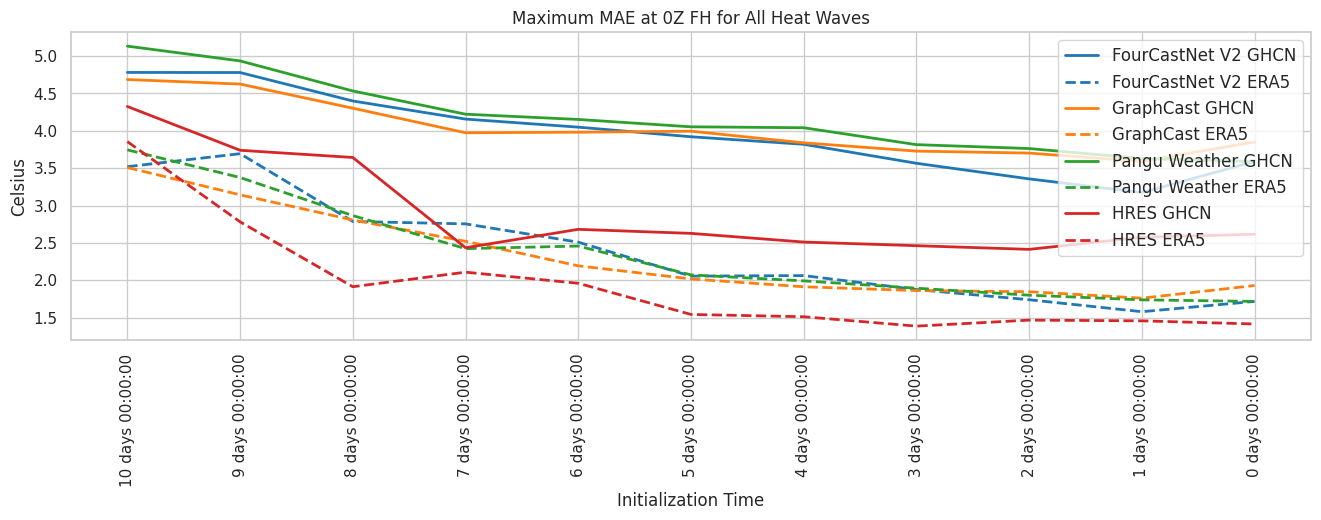

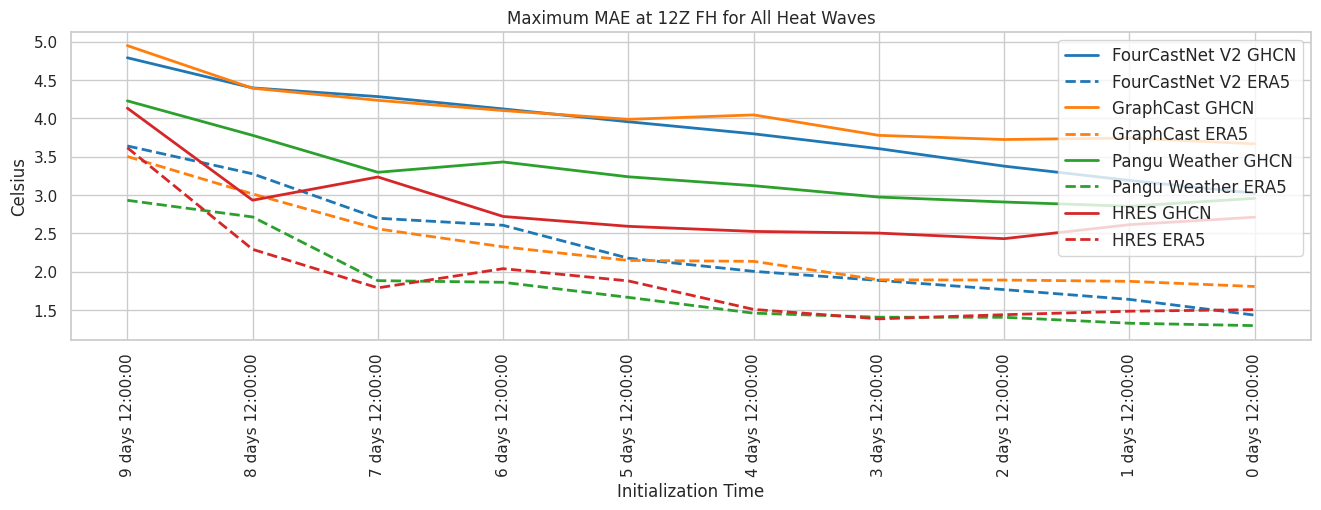

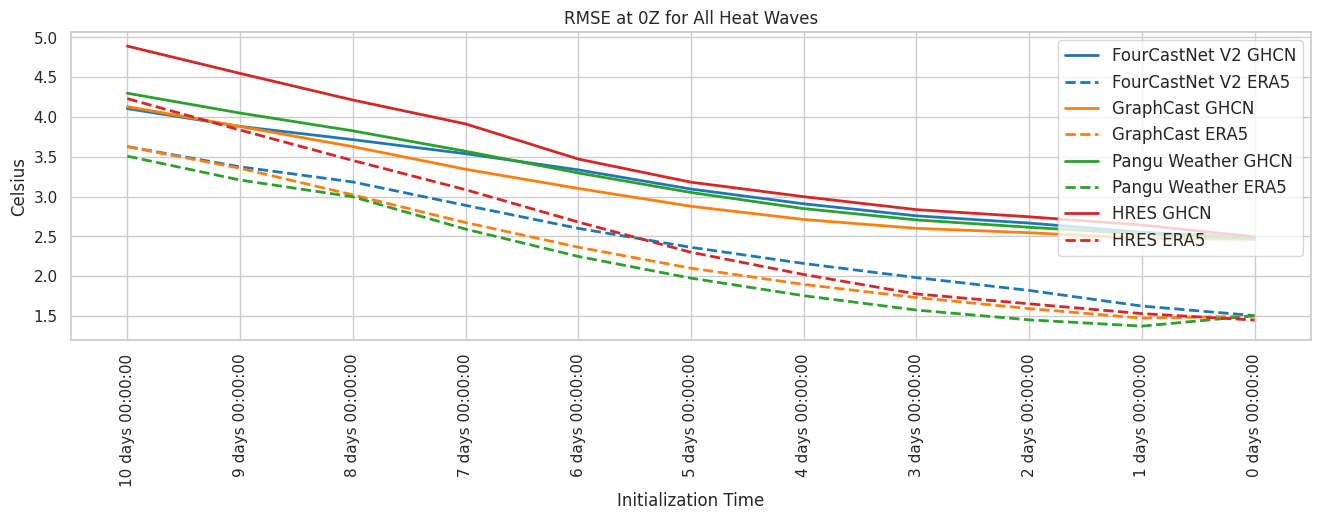

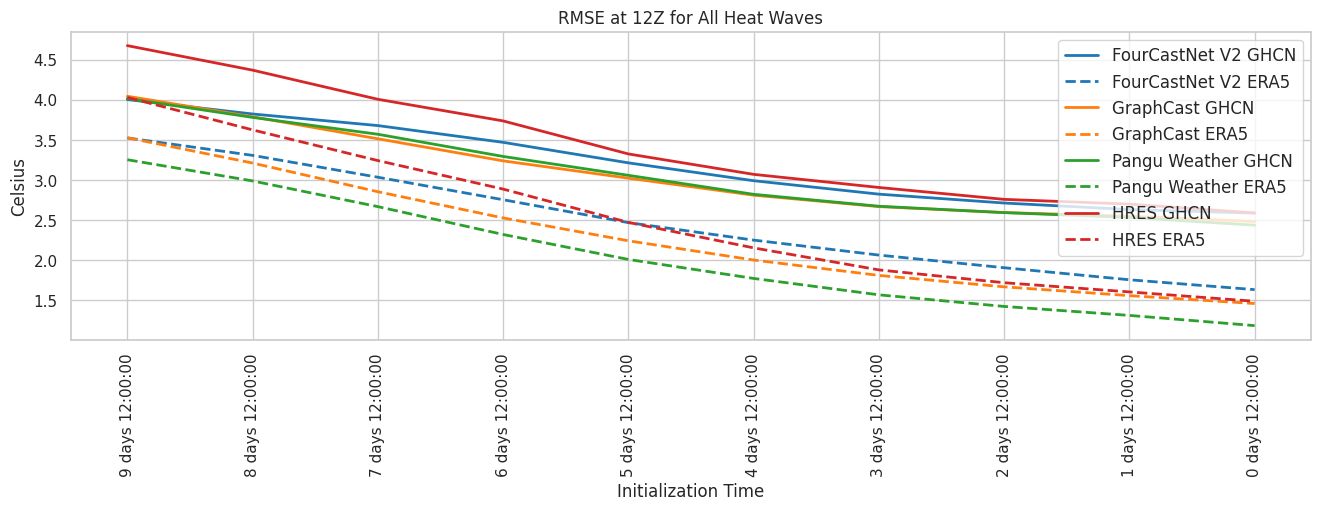

In [35]:
plot_results_by_metric(metric='maximum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_0z.png', 
                       title='Maximum MAE at 0Z FH for All Heat Waves', forecast_hour="zeroz")
plot_results_by_metric(metric='maximum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_12z.png', 
                       title='Maximum MAE at 12Z FH for All Heat Waves', forecast_hour="twelvez")

plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_rmse_0z.png', 
                       title='RMSE at 0Z for All Heat Waves', forecast_hour="zeroz")
plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_rmse_12z.png', 
                       title='RMSE at 12Z for All Heat Waves', forecast_hour="twelvez")

# subset the data into regions

In [25]:
# helper function to convert a bounding box tuple to a shapely Polygon
def get_polygon_from_bounding_box(bounding_box):
    """Convert a bounding box tuple to a shapely Polygon."""
    if bounding_box is None:
        return None
    left_lon, right_lon, bot_lat, top_lat = bounding_box
    return Polygon(
        [
            (left_lon, bot_lat),
            (right_lon, bot_lat),
            (right_lon, top_lat),
            (left_lon, top_lat),
            (left_lon, bot_lat),
        ]
    )

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = get_polygon_from_bounding_box(na_bounding_box)

# Europe bounding box
eu_bounding_box = [50, -15, 15, 75]
eu_bounding_box_polygon = get_polygon_from_bounding_box(eu_bounding_box)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = get_polygon_from_bounding_box(au_bounding_box)


In [26]:
# plot the boxes on a global map so we can see where they are

# helper function to plot a polygon on a cartopy axis
def plot_polygon(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor=color,
        edgecolor=color,
        alpha=alpha,
        linewidth=2,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)

# helper function to plot a polygon on a cartopy axis
def plot_polygon_outline(polygon, ax, color='yellow', alpha=0.5, my_zorder=1):
    """Plot a shapely Polygon on a Cartopy axis."""
    if polygon is None:
        return
    patch = patches.Polygon(
        polygon.exterior.coords,
        closed=True,
        facecolor='none',
        edgecolor=color,
        alpha=alpha,
        linewidth=2,
        zorder=my_zorder,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(patch)


# main plotting function for plotting all cases
def plot_boxes(box_list, box_names, title, filename=None):
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=1, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    # use seaborn color palette for colorblind friendly colors
    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    # Plot boxes for each case
    for box in box_list:
        plot_polygon_outline(box, ax, color='blue', alpha=1)

    plt.legend(loc='lower left', fontsize=12)
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

/tmp/ipykernel_27904/3761302962.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=12)


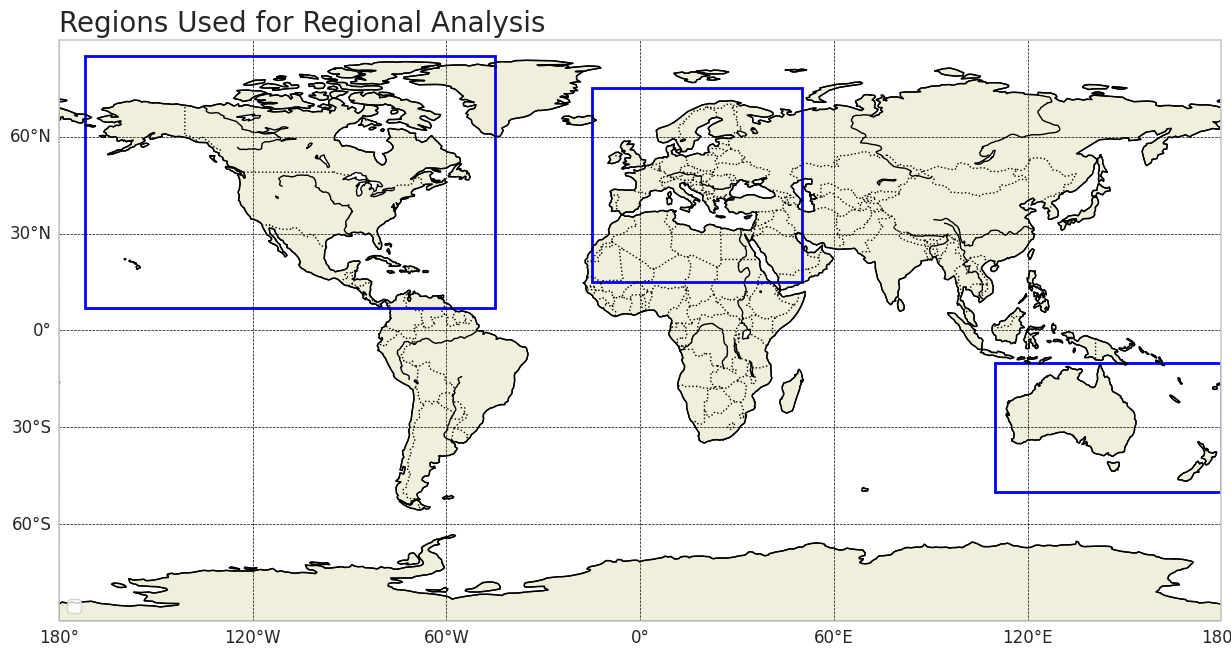

In [27]:
plot_boxes(
    box_list=[na_bounding_box_polygon, eu_bounding_box_polygon, au_bounding_box_polygon],
    box_names=['North America', 'Europe', 'Australia'],
    title='Regions Used for Regional Analysis',
    filename=basepath + 'docs/notebooks/figs/figure3_part1_regions.png'
)

In [28]:
# main plotting function for plotting all cases
def plot_all_cases(ewb_cases, event_type=None, filename=None, bounding_box=None, fill_boxes=False, event_id=None):
    """A function to plot all cases
    Args:
        ewb_cases (list): A list of cases to plot.
        event_type (str): The type of event to plot. If None, all events will be plotted).
        filename (str): The name of the file to save the plot. If None, the plot will not be saved.
        bounding_box (tuple): A tuple of the form (min_lon, min_lat, max_lon, max_lat) to set the bounding box for the plot. If None, the full world map will be plotted.
    """
    # plot all cases on one giant world map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot the full map or a subset if bounding_box is specified
    if (bounding_box is None):
        ax.set_global()
    else:
        ax.set_extent(bounding_box, crs=ccrs.PlateCarree())
    
    # save the bounding box polygon to subset the counts later
    if (bounding_box is not None):
        bounding_box_polygon = get_polygon_from_bounding_box(bounding_box)
        #plot_polygon(bounding_box_polygon, ax, color='yellow', alpha=0.5)
        
    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    # Define colors for each event type
    # use seaborn color palette for colorblind friendly colors
    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    # event_colors = {
    #     'heat_wave': 'firebrick',
    #     'tropical_cyclone': 'darkorange',
    #     'severe_convection': 'orchid',
    #     'atmospheric_river': 'mediumseagreen',
    #     'freeze': 'royalblue',   
    # }
    event_colors = {
            'freeze': sns_palette[0],  
            'heat_wave': sns_palette[3],
            'tropical_cyclone': sns_palette[1],
            'severe_convection': sns_palette[5],
            'atmospheric_river': sns_palette[7],
        }

    # Initialize counts for each event type
    counts_by_type = dict({'freeze': 0, 'heat_wave': 0, 'severe_convection': 0, 'atmospheric_river': 0, 'tropical_cyclone': 0})
    zorders = {'freeze': 10, 'heat_wave': 9, 'atmospheric_river': 2, 'tropical_cyclone': 1, 'severe_convection': 0}
    alphas = {'freeze': 0.2, 'heat_wave': 0.2, 'atmospheric_river': 0.2, 'tropical_cyclone': 0.2, 'severe_convection': 0.05}

    # Plot boxes for each case
    for indiv_case in ewb_cases.cases:
        # Get color based on event type
        indiv_event_type = indiv_case.event_type
        color = event_colors.get(indiv_event_type, 'gray')  # Default to gray if event type not found

        # check if the case is inside the bounding box
        if bounding_box is not None:
            if (not shapely.intersects(indiv_case.location.geopandas.geometry[0], bounding_box_polygon)):
                #print(f"Skipping case {indiv_case.case_id_number} as it is outside the bounding box.")
                continue
        
        # Plot the case geopandas info
        if (event_type is None or indiv_event_type == event_type and event_id is None) or (event_id is not None and indiv_case.case_id_number == event_id):
            if (fill_boxes):
                # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
                # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
                if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                    for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                        plot_polygon(poly, ax, color=color, alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
                else:
                    plot_polygon(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                                alpha=alphas[indiv_event_type], my_zorder=zorders[indiv_event_type])
            else:
                # to handle wrapping around the prime meridian, we can't use geopandas plot (and besides it is slow)
                # instead we have multi-polygon patches if it wraps around and we need to plot each polygon separately
                if isinstance(indiv_case.location.geopandas.geometry.iloc[0], shapely.geometry.MultiPolygon):
                    for poly in indiv_case.location.geopandas.geometry.iloc[0].geoms:
                        plot_polygon_outline(poly, ax, color=color, alpha=1, my_zorder=zorders[indiv_event_type])
                else:
                    plot_polygon_outline(indiv_case.location.geopandas.geometry.iloc[0], ax, color=color, 
                                alpha=1, my_zorder=zorders[indiv_event_type])

            # count the events by type
            counts_by_type[indiv_event_type] += 1

        
    # Create a custom legend for event types
    if (event_type is not None):
        # if we are only plotting one event type, only show that in the legend
        legend_elements = [
            Patch(facecolor=event_colors[event_type], alpha=0.9, label=f'{event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]),
        ]
    else:
        # otherwise show all event types in the legend
        legend_elements = [
            Patch(facecolor=event_colors['heat_wave'], alpha=0.9, label='Heat Wave (n = %d)' % counts_by_type['heat_wave']),
            Patch(facecolor=event_colors['freeze'], alpha=0.9, label='Freeze (n = %d)' % counts_by_type['freeze']),
            Patch(facecolor=event_colors['severe_convection'], alpha=0.9, label='Convection (n = %d)' % counts_by_type['severe_convection']),
            Patch(facecolor=event_colors['atmospheric_river'], alpha=0.9, label='Atmospheric River (n = %d)' % counts_by_type['atmospheric_river']),
            Patch(facecolor=event_colors['tropical_cyclone'], alpha=0.9, label='Tropical Cyclone (n = %d)' % counts_by_type['tropical_cyclone']),
        ]

    # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    if (event_type is None):
        title = 'ExtremeWeatherBench Cases (n = %d)' % sum(counts_by_type.values())
    else:
        title = f'ExtremeWeatherBench Cases: {event_type.replace("_", " ").title()} (n = %d)' % counts_by_type[event_type]

    if (event_id is not None):
        title = f'ExtremeWeatherBench Case ID: {event_id}'
    
    ax.set_title(title, loc='left', fontsize=20)
    
    # save if there is a filename specified (otherwise the user just wants to see the plot)
    if filename is not None:
        plt.savefig(filename, transparent=False, bbox_inches='tight', dpi=300)

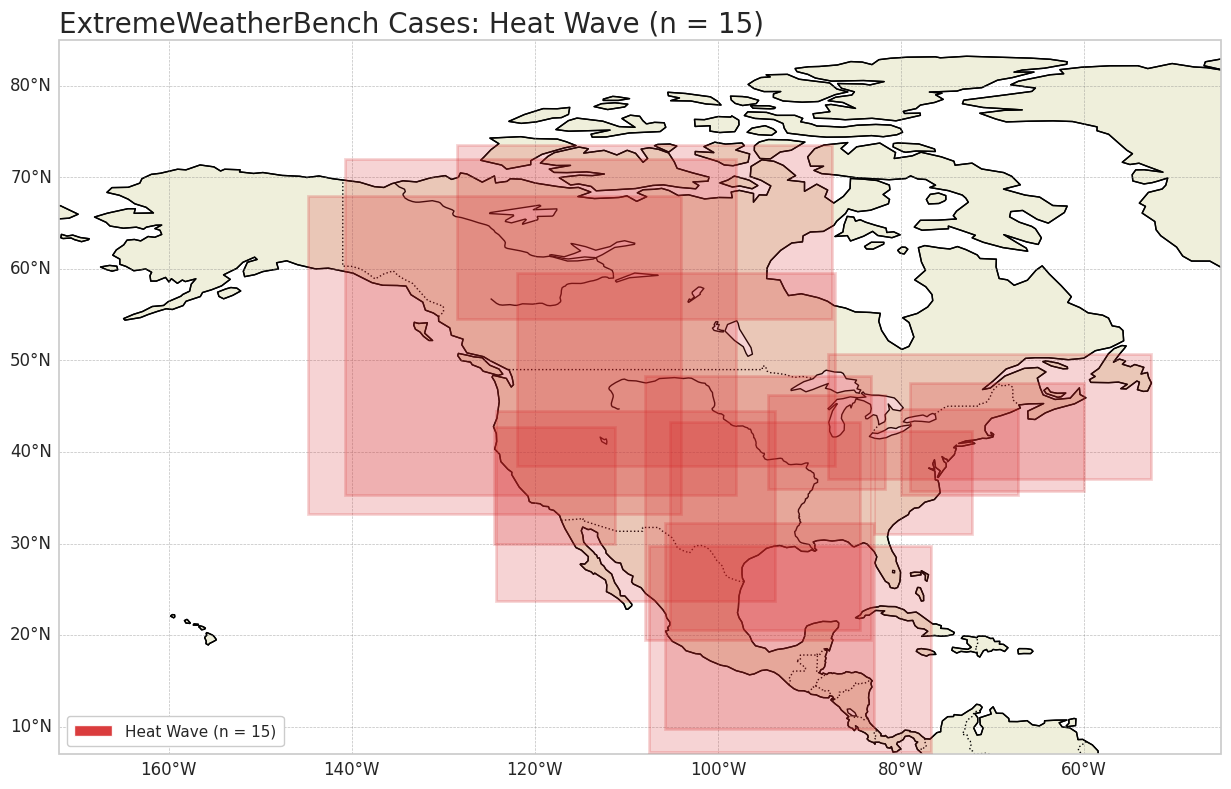

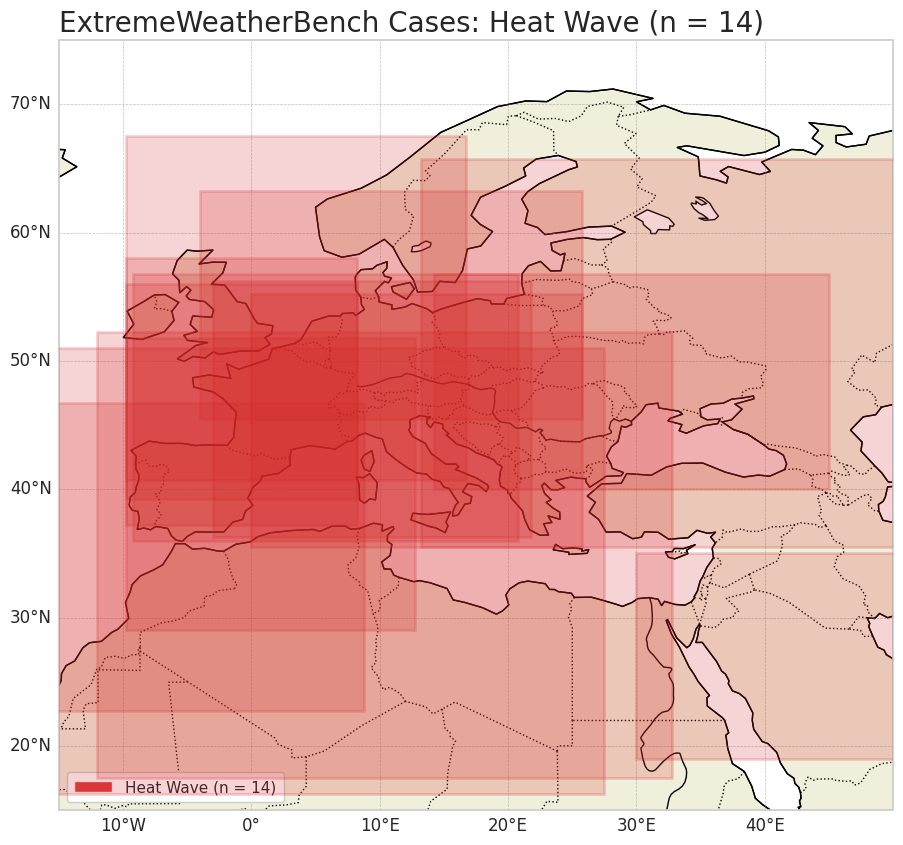

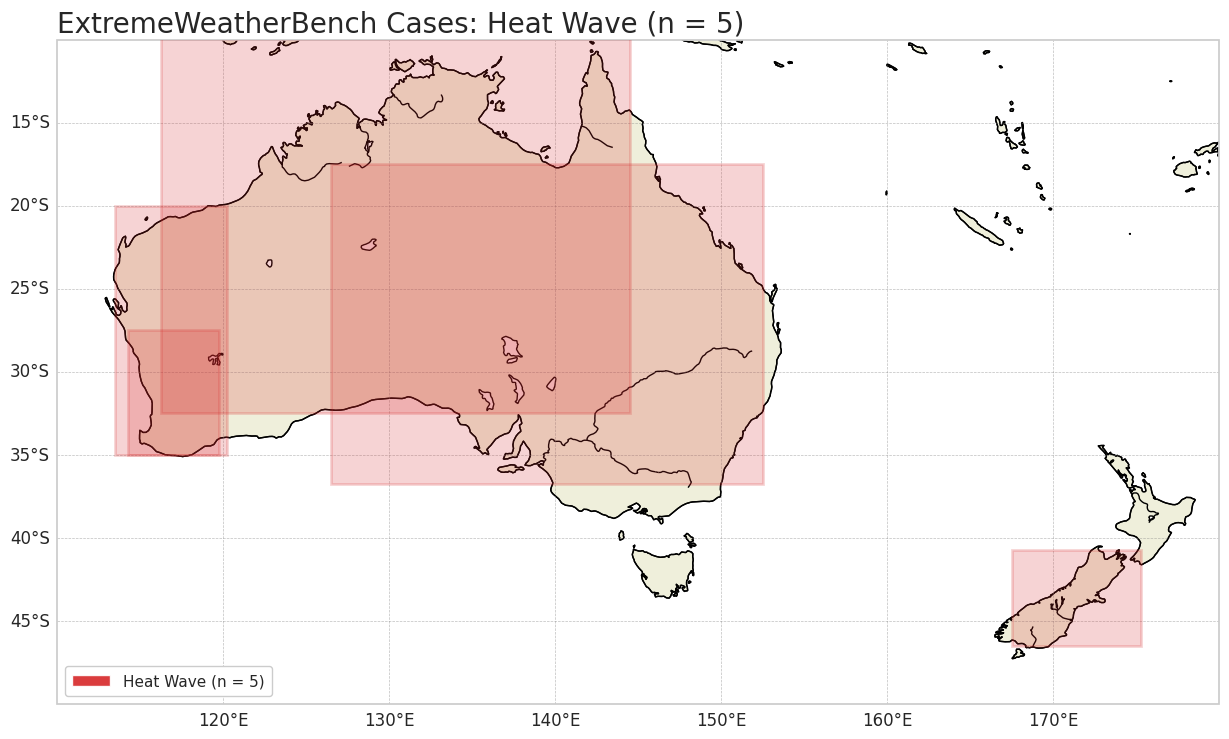

In [29]:
# plot North America cases
plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=na_bounding_box, 
               filename=basepath + 'docs/notebooks/figs/extreme_weather_heat_cases_NA.png', fill_boxes=True)

plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=eu_bounding_box, 
               filename=basepath + 'docs/notebooks/figs/extreme_weather_heat_cases_EU.png', fill_boxes=True)

plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=au_bounding_box, 
               filename=basepath + 'docs/notebooks/figs/extreme_weather_heat_cases_AU.png', fill_boxes=True)

In [30]:
na_cases = list()
eu_cases = list()
au_cases = list()

for heat_case in ewb_fourv2_era5.case_operators:
    #print(heat_case.case_metadata)

    my_case = heat_case.case_metadata

    # collect the North America, Europe, and Australia cases
    if (shapely.intersects(my_case.location.geopandas.geometry[0], na_bounding_box_polygon)):
        na_cases.append(my_case.case_id_number)
    elif (shapely.intersects(my_case.location.geopandas.geometry[0], eu_bounding_box_polygon)):
        eu_cases.append(my_case.case_id_number)
    elif (shapely.intersects(my_case.location.geopandas.geometry[0], au_bounding_box_polygon)):
        au_cases.append(my_case.case_id_number)

print(f'North America Cases: {na_cases}')
print(f'Europe Cases: {eu_cases}')
print(f'Australia Cases: {au_cases}')


North America Cases: [1, 2, 3, 4, 5, 6, 27, 72, 73, 74, 75, 76, 77, 79, 86]
Europe Cases: [8, 9, 10, 14, 15, 18, 19, 20, 21, 22, 82, 83, 84, 85]
Australia Cases: [7, 26, 28, 29, 80]


In [31]:
# make all the subsets
na_fourv2_era5_results = fourv2_era5_results[fourv2_era5_results['case_id_number'].isin(na_cases)]
eu_fourv2_era5_results = fourv2_era5_results[fourv2_era5_results['case_id_number'].isin(eu_cases)]
au_fourv2_era5_results = fourv2_era5_results[fourv2_era5_results['case_id_number'].isin(au_cases)]

na_fourv2_ghcn_results = fourv2_ghcn_results[fourv2_ghcn_results['case_id_number'].isin(na_cases)]
eu_fourv2_ghcn_results = fourv2_ghcn_results[fourv2_ghcn_results['case_id_number'].isin(eu_cases)]
au_fourv2_ghcn_results = fourv2_ghcn_results[fourv2_ghcn_results['case_id_number'].isin(au_cases)]

na_pang_era5_results = pang_era5_results[pang_era5_results['case_id_number'].isin(na_cases)]
eu_pang_era5_results = pang_era5_results[pang_era5_results['case_id_number'].isin(eu_cases)]
au_pang_era5_results = pang_era5_results[pang_era5_results['case_id_number'].isin(au_cases)]

na_pang_ghcn_results = pang_ghcn_results[pang_ghcn_results['case_id_number'].isin(na_cases)]
eu_pang_ghcn_results = pang_ghcn_results[pang_ghcn_results['case_id_number'].isin(eu_cases)]
au_pang_ghcn_results = pang_ghcn_results[pang_ghcn_results['case_id_number'].isin(au_cases)]    

na_hres_era5_results = hres_era5_results[hres_era5_results['case_id_number'].isin(na_cases)]
eu_hres_era5_results = hres_era5_results[hres_era5_results['case_id_number'].isin(eu_cases)]
au_hres_era5_results = hres_era5_results[hres_era5_results['case_id_number'].isin(au_cases)]

na_hres_ghcn_results = hres_ghcn_results[hres_ghcn_results['case_id_number'].isin(na_cases)]
eu_hres_ghcn_results = hres_ghcn_results[hres_ghcn_results['case_id_number'].isin(eu_cases)]
au_hres_ghcn_results = hres_ghcn_results[hres_ghcn_results['case_id_number'].isin(au_cases)]

na_gc_ghcn_results = gc_ghcn_results[gc_ghcn_results['case_id_number'].isin(na_cases)]
eu_gc_ghcn_results = gc_ghcn_results[gc_ghcn_results['case_id_number'].isin(eu_cases)]
au_gc_ghcn_results = gc_ghcn_results[gc_ghcn_results['case_id_number'].isin(au_cases)]

na_gc_era5_results = gc_era5_results[gc_era5_results['case_id_number'].isin(na_cases)]
eu_gc_era5_results = gc_era5_results[gc_era5_results['case_id_number'].isin(eu_cases)]
au_gc_era5_results = gc_era5_results[gc_era5_results['case_id_number'].isin(au_cases)]

In [32]:
# do the groupby for each subset
# fourcastnet v2
na_fourv2_ghcn_group = na_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_fourv2_era5_group = na_fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_fourv2_ghcn_group = eu_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_fourv2_ghcn_group = eu_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

au_fourv2_ghcn_group = au_fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
au_fourv2_era5_group = au_fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# graphcast
na_gc_ghcn_group = na_gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_gc_era5_group = na_gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_gc_ghcn_group = eu_gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_gc_era5_group = eu_gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

au_gc_ghcn_group = au_gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
au_gc_era5_group = au_gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# pangu
na_pang_ghcn_group = na_pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_pang_era5_group = na_pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_pang_ghcn_group = eu_pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eh_pang_era5_group = eu_pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

au_pang_era5_group = au_pang_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
au_pang_ghcn_group = au_pang_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

# hres
na_hres_ghcn_group = na_hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
na_hres_era5_group = na_hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

eu_hres_ghcn_group = eu_hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
eu_hres_era5_group = eu_hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

au_hres_era5_group = au_hres_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
au_hres_ghcn_group = au_hres_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()

In [36]:
def plot_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', 
                           fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results,
                           gc_ghcn=na_gc_ghcn_results,
                           global_fourv2_ghcn=fourv2_ghcn_results, global_pang_ghcn=pang_ghcn_results, global_hres_ghcn=hres_ghcn_results,
                           global_gc_ghcn=gc_ghcn_results,
                           forecast_hour=None):
    # make the pivot table so we can plot by lead time
    fourv2_ghcn_group = fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    fourv2_ghcn_pivot = fourv2_ghcn_group[fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    pang_ghcn_group = pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    pang_ghcn_pivot = pang_ghcn_group[pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    hres_ghcn_group = hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    hres_ghcn_pivot = hres_ghcn_group[hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    gc_ghcn_group = gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    gc_ghcn_pivot = gc_ghcn_group[gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    # grab the global results for reference lines
    global_fourv2_ghcn_group = global_fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_fourv2_ghcn_pivot = global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_pang_ghcn_group = global_pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_pang_ghcn_pivot = global_pang_ghcn_group[global_pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_hres_ghcn_group = global_hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_hres_ghcn_pivot = global_hres_ghcn_group[global_hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_gc_ghcn_group = global_gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_gc_ghcn_pivot = global_gc_ghcn_group[global_gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 0
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = fourv2_ghcn_pivot.columns.seconds % 86400 == 43200
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        fourv2_ghcn_pivot = fourv2_ghcn_pivot.iloc[:, my_times]
        pang_ghcn_pivot = pang_ghcn_pivot.iloc[:, my_times]
        hres_ghcn_pivot = hres_ghcn_pivot.iloc[:, my_times]
        gc_ghcn_pivot = gc_ghcn_pivot.iloc[:, my_times]

        global_fourv2_ghcn_pivot = global_fourv2_ghcn_pivot.iloc[:, my_times]
        global_pang_ghcn_pivot = global_pang_ghcn_pivot.iloc[:, my_times]
        global_hres_ghcn_pivot = global_hres_ghcn_pivot.iloc[:, my_times]  
        global_gc_ghcn_pivot = global_gc_ghcn_pivot.iloc[:, my_times]


    # make the plots
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(15,4))
    fourv2_ghcn_values = fourv2_ghcn_pivot.loc[metric].values
    pang_ghcn_values = pang_ghcn_pivot.loc[metric].values
    hres_ghcn_values = hres_ghcn_pivot.loc[metric].values
    gc_ghcn_values = gc_ghcn_pivot.loc[metric].values

    global_fourv2_ghcn_values = global_fourv2_ghcn_pivot.loc[metric].values
    global_pang_ghcn_values = global_pang_ghcn_pivot.loc[metric].values
    global_hres_ghcn_values = global_hres_ghcn_pivot.loc[metric].values
    global_gc_ghcn_values = global_gc_ghcn_pivot.loc[metric].values

    sns_palette = sns.color_palette("tab10")
    sns.set_style("whitegrid")

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2 GHCN')
    plt.plot(np.flip(global_fourv2_ghcn_values), color=fourv2_color, linestyle='--', label='Global FourCastNet V2 GHCN')

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather GHCN')
    plt.plot(np.flip(global_pang_ghcn_values), color=pangu_color, linestyle='--', label='Global Pangu Weather GHCN')

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES GHCN')
    plt.plot(np.flip(global_hres_ghcn_values), color=hres_color, linestyle='--', label='Global HRES GHCN')

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast GHCN')
    plt.plot(np.flip(global_gc_ghcn_values), color=gc_color, linestyle='--', label='Global GraphCast GHCN')

    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn_pivot.columns), ticks=np.arange(0, len(fourv2_ghcn_pivot.columns)))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend()

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)


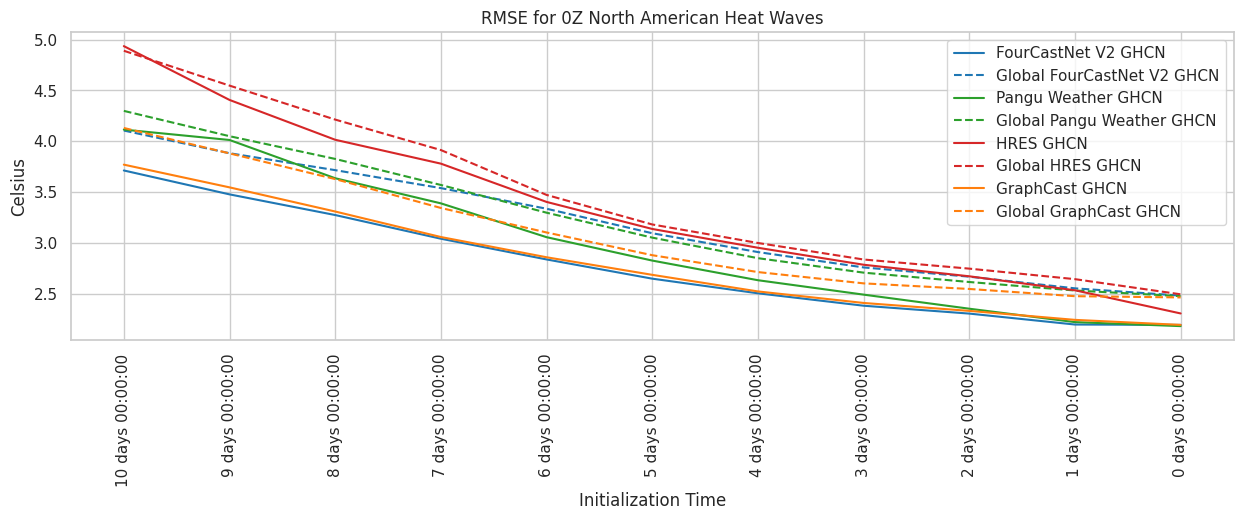

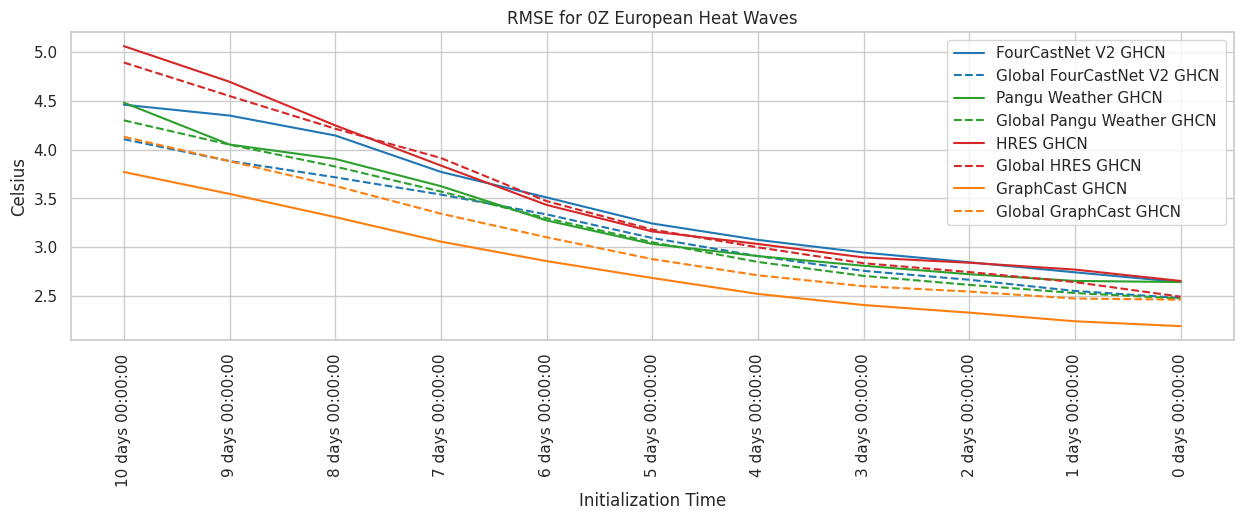

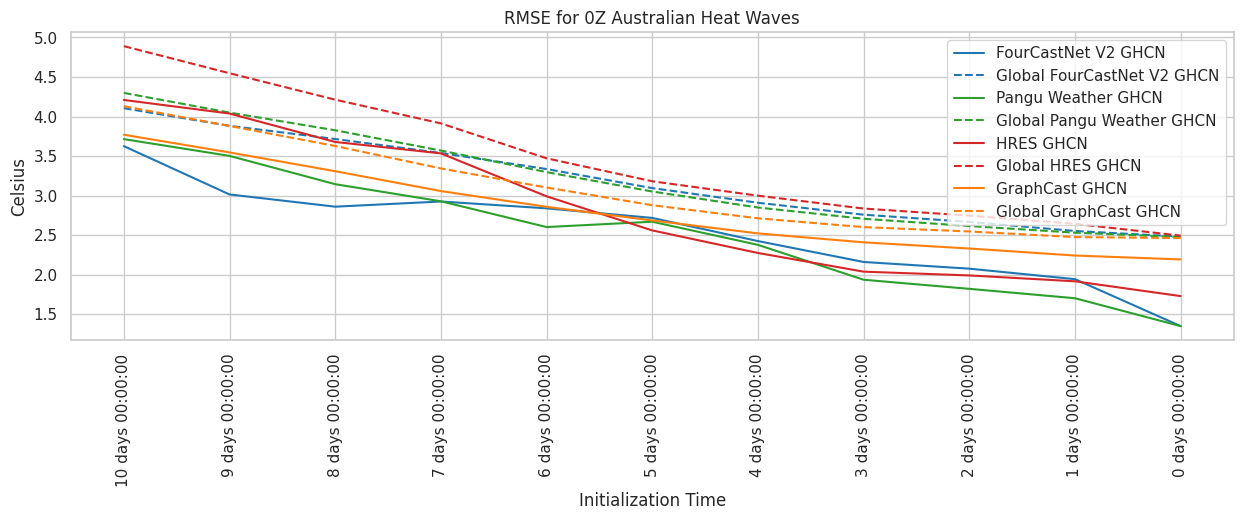

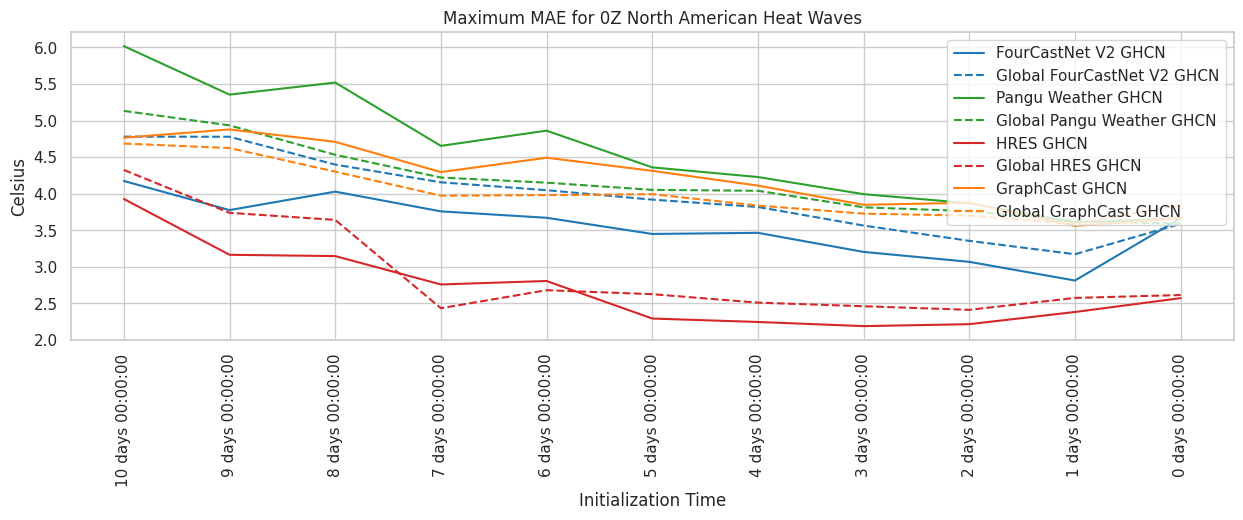

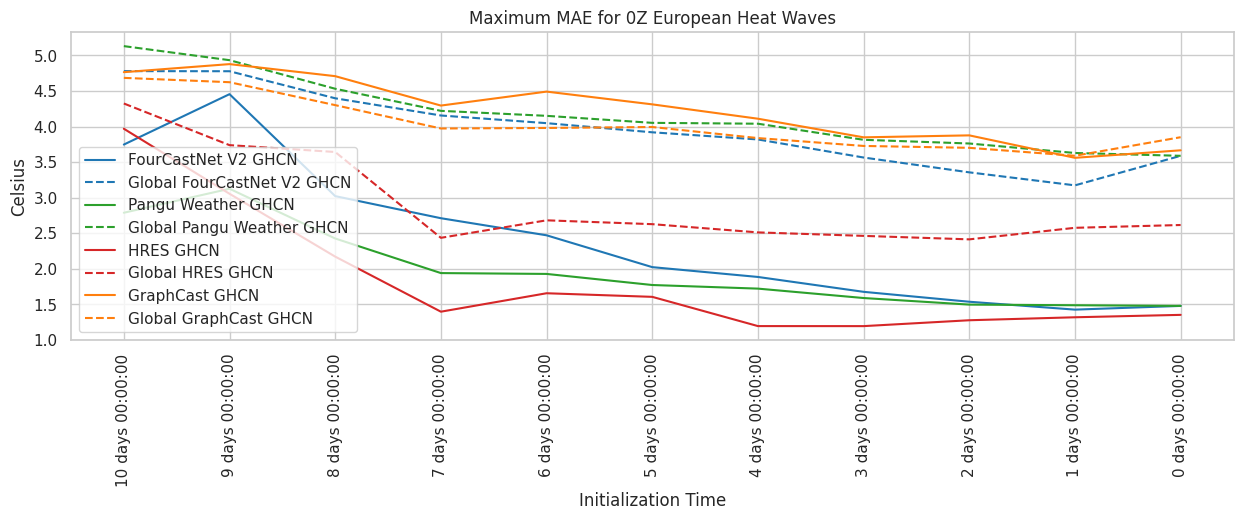

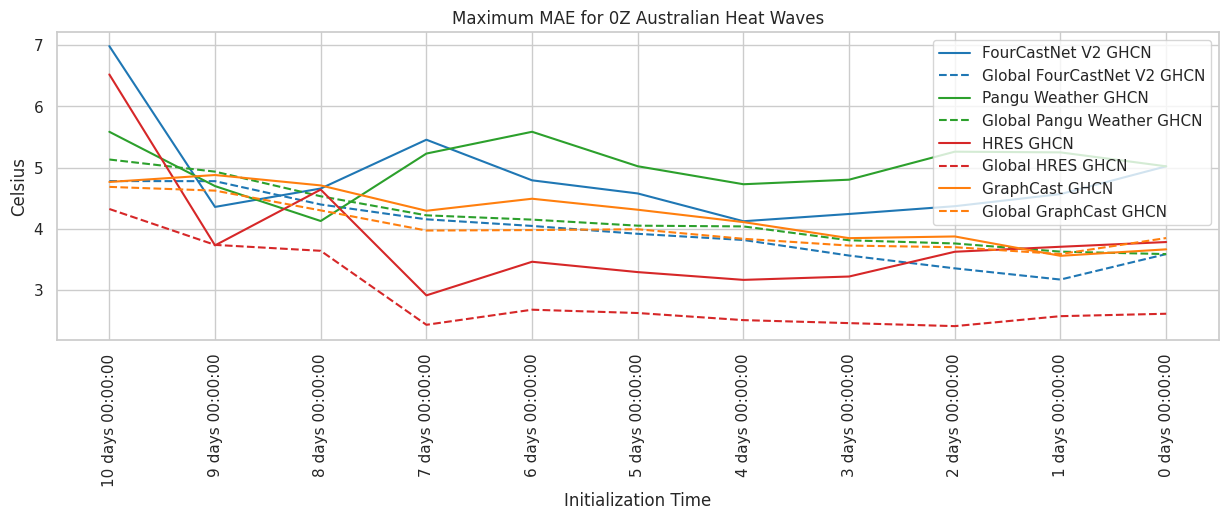

In [37]:
plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', title='RMSE for 0Z North American Heat Waves', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       forecast_hour='zeroz')

plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', title='RMSE for 0Z European Heat Waves', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')

plot_results_by_metric(metric='rmse', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_au.png', title='RMSE for 0Z Australian Heat Waves', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=au_fourv2_ghcn_results, pang_ghcn=au_pang_ghcn_results, hres_ghcn=au_hres_ghcn_results, forecast_hour='zeroz')


plot_results_by_metric(metric='maximum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_na.png', 
                       title='Maximum MAE for 0Z North American Heat Waves', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, forecast_hour='zeroz')

plot_results_by_metric(metric='maximum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_eu.png', 
                       title='Maximum MAE for 0Z European Heat Waves', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=eu_fourv2_ghcn_results, pang_ghcn=eu_pang_ghcn_results, hres_ghcn=eu_hres_ghcn_results, forecast_hour='zeroz')

plot_results_by_metric(metric='maximum_mae', filename=basepath + 'docs/notebooks/figs/figure2_part2_maximum_mae_au.png', 
                       title='Maximum MAE for 0Z Australian Heat Waves', 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       fourv2_ghcn=au_fourv2_ghcn_results, pang_ghcn=au_pang_ghcn_results, hres_ghcn=au_hres_ghcn_results, forecast_hour
                       ='zeroz')


In [38]:
# look through the north america cases to decide which one to look in depth
for heat_case in ewb_cases.cases:
    
    if (heat_case.case_id_number in na_cases):
        print(heat_case)  

        #plot_all_cases(ewb_cases, event_type='heat_wave', bounding_box=na_bounding_box, fill_boxes=True, event_id=my_case.case_id_number)



IndividualCase(case_id_number=1, title='2021 Pacific Northwest', start_date=datetime.datetime(2021, 6, 20, 0, 0), end_date=datetime.datetime(2021, 7, 3, 0, 0), location=BoundingBoxRegion(latitude_min=33.25, latitude_max=68.0, longitude_min=215.25, longitude_max=256.0), event_type='heat_wave')
IndividualCase(case_id_number=2, title='2022 Upper Midwest', start_date=datetime.datetime(2022, 5, 7, 0, 0), end_date=datetime.datetime(2022, 5, 17, 0, 0), location=BoundingBoxRegion(latitude_min=19.5, latitude_max=48.25, longitude_min=252.0, longitude_max=276.75), event_type='heat_wave')
IndividualCase(case_id_number=3, title='2022 California', start_date=datetime.datetime(2022, 6, 7, 0, 0), end_date=datetime.datetime(2022, 6, 15, 0, 0), location=BoundingBoxRegion(latitude_min=23.75, latitude_max=44.5, longitude_min=235.75, longitude_max=266.25), event_type='heat_wave')
IndividualCase(case_id_number=4, title='2022 Texas', start_date=datetime.datetime(2022, 6, 30, 0, 0), end_date=datetime.datetime

In [39]:
# going to dive into case 3 in more detail
for case in ewb_cases.cases:
    if (case.case_id_number == 3):
        my_case = case
        print(my_case)
        break

IndividualCase(case_id_number=3, title='2022 California', start_date=datetime.datetime(2022, 6, 7, 0, 0), end_date=datetime.datetime(2022, 6, 15, 0, 0), location=BoundingBoxRegion(latitude_min=23.75, latitude_max=44.5, longitude_min=235.75, longitude_max=266.25), event_type='heat_wave')


In [40]:
na_fourv2_era5_results[na_fourv2_era5_results['case_id_number'] == my_case.case_id_number]

,value,lead_time,init_time,target_variable,metric,forecast_source,target_source,case_id_number,event_type
199,0.867126,0 days 00:00:00,NaN,surface_air_temperature,maximum_mae,CIRA FOURv2,ERA5,3,heat_wave
200,1.33017,0 days 06:00:00,NaN,surface_air_temperature,maximum_mae,CIRA FOURv2,ERA5,3,heat_wave
201,0.098083,0 days 12:00:00,NaN,surface_air_temperature,maximum_mae,CIRA FOURv2,ERA5,3,heat_wave
202,1.517334,0 days 18:00:00,NaN,surface_air_temperature,maximum_mae,CIRA FOURv2,ERA5,3,heat_wave
203,0.135864,1 days 00:00:00,NaN,surface_air_temperature,maximum_mae,CIRA FOURv2,ERA5,3,heat_wave
...,...,...,...,...,...,...,...,...,...
387,NaN,9 days 00:00:00,NaN,surface_air_temperature,max_min_mae,CIRA FOURv2,ERA5,3,heat_wave
388,NaN,9 days 06:00:00,NaN,surface_air_temperature,max_min_mae,CIRA FOURv2,ERA5,3,heat_wave
389,NaN,9 days 12:00:00,NaN,surface_air_temperature,max_min_mae,CIRA FOURv2,ERA5,3,heat_wave
390,NaN,9 days 18:00:00,NaN,surface_air_temperature,max_min_mae,CIRA FOURv2,ERA5,3,heat_wave


In [46]:
def plot_individual_case_results_by_metric(metric='rmse', filename=None, title='RMSE for All Heat Waves', 
                           fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results,
                           gc_ghcn=na_gc_ghcn_results,
                           global_fourv2_ghcn=fourv2_ghcn_results, global_pang_ghcn=pang_ghcn_results, global_hres_ghcn=hres_ghcn_results,
                           global_gc_ghcn=gc_ghcn_results,
                           forecast_hour=None, event_id=None):
    
    # subset the results to just this metric and event id
    fourv2_ghcn = fourv2_ghcn[fourv2_ghcn['case_id_number'] == my_case.case_id_number]
    fourv2_ghcn = fourv2_ghcn[fourv2_ghcn['metric'] == metric]
    lead_times = fourv2_ghcn['lead_time'].values

    pang_ghcn = pang_ghcn[pang_ghcn['case_id_number'] == my_case.case_id_number]
    pang_ghcn = pang_ghcn[pang_ghcn['metric'] == metric]

    hres_ghcn = hres_ghcn[hres_ghcn['case_id_number'] == my_case.case_id_number]
    hres_ghcn = hres_ghcn[hres_ghcn['metric'] == metric]

    gc_ghcn = gc_ghcn[gc_ghcn['case_id_number'] == my_case.case_id_number]
    gc_ghcn = gc_ghcn[gc_ghcn['metric'] == metric]

    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        my_times = [idx for idx, n in enumerate(lead_times) if n.seconds % 86400 == 0]
    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        my_times = [idx for idx, n in enumerate(lead_times) if n.seconds % 86400 == 43200]

    # if forecast hour is specified, grab the runs matching those times
    if (forecast_hour is not None):
        fourv2_ghcn = fourv2_ghcn.iloc[my_times]
        pang_ghcn = pang_ghcn.iloc[my_times]
        hres_ghcn = hres_ghcn.iloc[my_times] 
        gc_ghcn = gc_ghcn.iloc[my_times]   


     # grab the global results for reference lines
    global_fourv2_ghcn_group = global_fourv2_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_fourv2_ghcn_pivot = global_fourv2_ghcn_group[global_fourv2_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_pang_ghcn_group = global_pang_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_pang_ghcn_pivot = global_pang_ghcn_group[global_pang_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_hres_ghcn_group = global_hres_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_hres_ghcn_pivot = global_hres_ghcn_group[global_hres_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

    global_gc_ghcn_group = global_gc_ghcn[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean().reset_index()
    global_gc_ghcn_pivot = global_gc_ghcn_group[global_gc_ghcn_group['metric']==metric].pivot(index='metric', columns='lead_time', values='value')

     # if forecast hour is specified, grab the runs matching those times
    
    if (forecast_hour == "zeroz"):
        # extract the 0z runs
        time_diff = global_fourv2_ghcn_pivot.columns.seconds % 86400 == 0
        my_times = [idx for idx, n in enumerate(time_diff) if n]
    elif (forecast_hour == "twelvez"):
        # extract the 12z runs
        time_diff = global_fourv2_ghcn_pivot.columns.seconds % 86400 == 43200
        my_times = [idx for idx, n in enumerate(time_diff) if n]

    if (forecast_hour is not None):
        global_fourv2_ghcn_pivot = global_fourv2_ghcn_pivot.iloc[:, my_times]
        global_pang_ghcn_pivot = global_pang_ghcn_pivot.iloc[:, my_times]
        global_hres_ghcn_pivot = global_hres_ghcn_pivot.iloc[:, my_times]  
        global_gc_ghcn_pivot = global_gc_ghcn_pivot.iloc[:, my_times]



    #print(fourv2_ghcn)

    # make the plots
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(15,4))
    fourv2_ghcn_values = fourv2_ghcn['value'].values
    pang_ghcn_values = pang_ghcn['value'].values
    hres_ghcn_values = hres_ghcn['value'].values
    gc_ghcn_values = gc_ghcn['value'].values

    global_fourv2_ghcn_values = global_fourv2_ghcn_pivot.loc[metric].values
    global_pang_ghcn_values = global_pang_ghcn_pivot.loc[metric].values
    global_hres_ghcn_values = global_hres_ghcn_pivot.loc[metric].values
    global_gc_ghcn_values = global_gc_ghcn_pivot.loc[metric].values

    #print(fourv2_ghcn_values)

    plt.plot(np.flip(fourv2_ghcn_values), color=fourv2_color, label='FourCastNet V2 GHCN')
    plt.plot(np.flip(global_fourv2_ghcn_values), color=fourv2_color, linestyle=':', label='Global FourCastNet V2 GHCN')

    plt.plot(np.flip(pang_ghcn_values), color=pangu_color, label='Pangu Weather GHCN')
    plt.plot(np.flip(global_pang_ghcn_values), color=pangu_color, linestyle=':', label='Global Pangu Weather GHCN')

    plt.plot(np.flip(hres_ghcn_values), color=hres_color, label='HRES GHCN')
    plt.plot(np.flip(global_hres_ghcn_values), color=hres_color, linestyle=':', label='Global HRES GHCN')

    plt.plot(np.flip(gc_ghcn_values), color=gc_color, label='GraphCast GHCN')
    plt.plot(np.flip(global_gc_ghcn_values), color=gc_color, linestyle=':', label='Global GraphCast GHCN')

    # make the xticklabels more readable and show every other one
    # print(np.arange(0, len(merged_pivot.columns), 2))
    # print(merged_pivot.columns[::2])
    ax.set_xticks(rotation=90, labels=np.flip(fourv2_ghcn['lead_time']), ticks=np.arange(0, len(fourv2_ghcn_values)))
    #ax.set_xticks(ticks=np.arange(0, len(merged_pivot.columns), 2))

    ax.set_ylabel('Celsius')
    ax.set_xlabel('Initialization Time')
    plt.title(title)
    #ax.grid(True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.5)
    plt.legend()

    if (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)

In [42]:
fourv2_ghcn = na_fourv2_ghcn_results[na_fourv2_ghcn_results['case_id_number'] == my_case.case_id_number]
fourv2_ghcn = fourv2_ghcn[fourv2_ghcn['metric'] == 'rmse']
lead_times = fourv2_ghcn['lead_time'].values
#print(lead_times)

my_times = [idx for idx, n in enumerate(lead_times) if n.seconds % 86400 == 0]
print(my_times)

# grab the runs matching those times
fourv2_ghcn.iloc[my_times]



[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]


,value,lead_time,init_time,target_variable,metric,forecast_source,target_source,case_id_number,event_type
240,2.379043,0 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
244,2.43116,1 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
248,2.579227,2 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
252,2.664766,3 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
256,2.822988,4 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
260,3.087294,5 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
264,3.301711,6 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
268,3.715267,7 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
272,4.145712,8 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave
276,4.333963,9 days 00:00:00,NaN,surface_air_temperature,rmse,CIRA FOURv2,GHCN,3,heat_wave


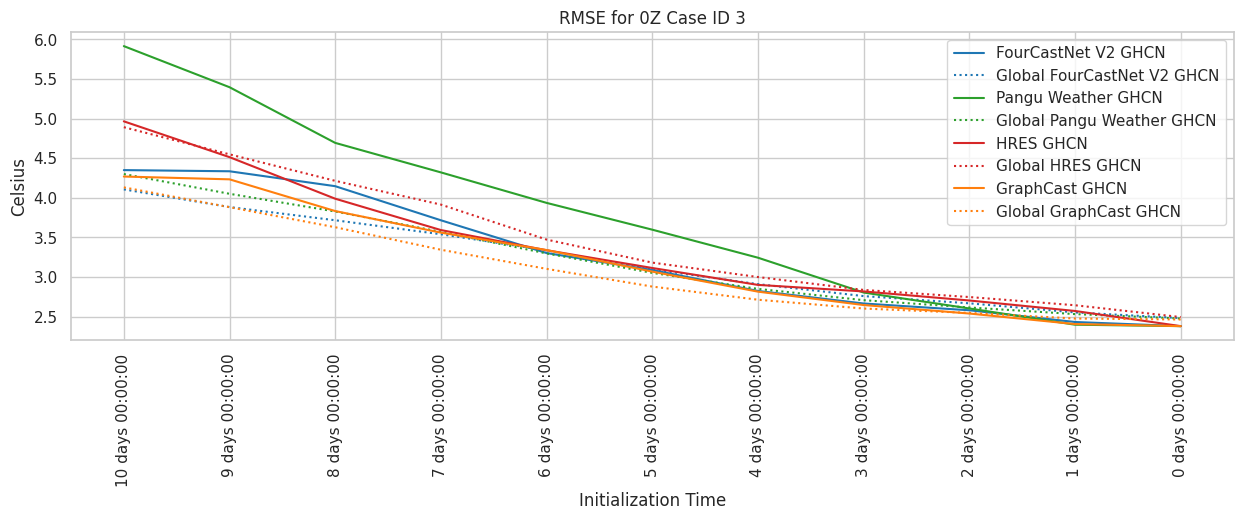

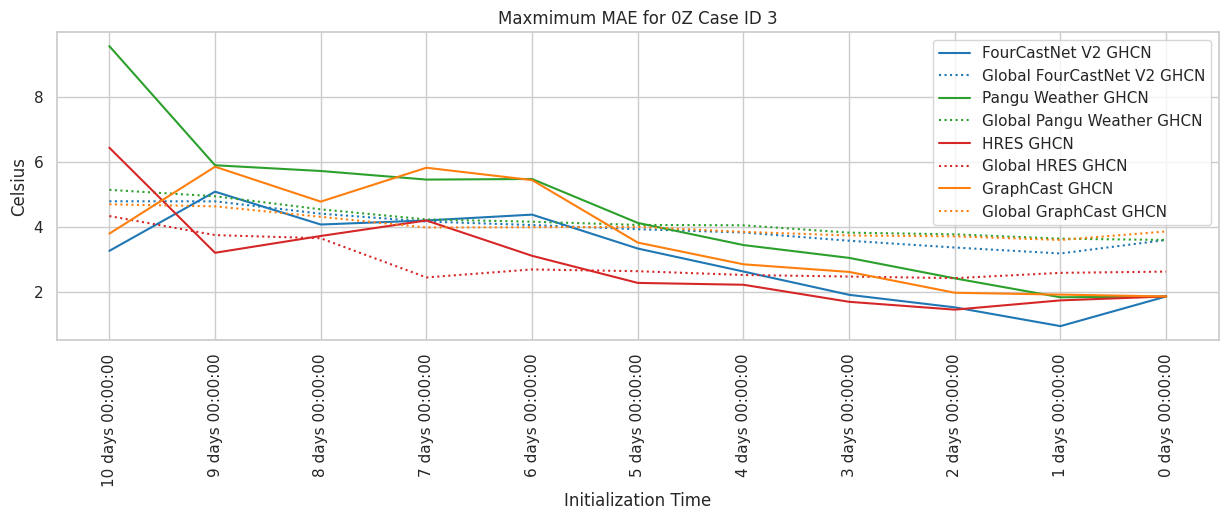

In [47]:
plot_individual_case_results_by_metric(metric='rmse', title='RMSE for 0Z Case ID 3', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       forecast_hour='zeroz', event_id=my_case.case_id_number)

plot_individual_case_results_by_metric(metric='maximum_mae', title='Maxmimum MAE for 0Z Case ID 3', 
                       fourv2_ghcn=na_fourv2_ghcn_results, pang_ghcn=na_pang_ghcn_results, hres_ghcn=na_hres_ghcn_results, 
                       global_fourv2_ghcn=fourv2_ghcn_results, global_hres_ghcn=hres_ghcn_results, global_pang_ghcn=pang_ghcn_results,
                       forecast_hour='zeroz', event_id=my_case.case_id_number)